# 03 - Entrainement du Modele de Diffusion (DDPM)

Ce notebook entraine un DDPM (Denoising Diffusion Probabilistic Model)
pour generer des images satellites synthetiques de secheresse.

**Pipeline :**
1. Preparer les images du domaine secheresse (generees par CycleGAN ou simulees)
2. Visualiser le processus de diffusion (ajout progressif de bruit)
3. Initialiser le DDPM (U-Net + scheduler) avec sauvegarde Drive
4. Entrainer (~4-6h sur GPU T4 Colab) avec auto-resume
5. Generer des echantillons et evaluer la qualite visuelle
6. Sauvegarder le modele final dans Drive

In [ ]:
"""
Configuration Google Drive pour sauvegarde outputs.
Les notebooks restent sur GitHub, seuls les checkpoints/resultats vont dans Drive.
"""

from google.colab import drive
import os
import sys

# Montage Drive
drive.mount('/content/drive', force_remount=True)

# Chemin racine pour les outputs uniquement
DRIVE_OUTPUTS = "/content/drive/MyDrive/SatelliteGAN-Outputs"

# Creation structure outputs
for subdir in [
    'data/eurosat', 'data/processed_drought',
    'cyclegan/checkpoints', 'cyclegan/generated_images', 'cyclegan/losses',
    'diffusion/checkpoints', 'diffusion/samples', 'diffusion/losses',
    'evaluation/metrics', 'evaluation/comparisons', 'evaluation/figures',
]:
    os.makedirs(f"{DRIVE_OUTPUTS}/{subdir}", exist_ok=True)

print(f"Drive monte : {DRIVE_OUTPUTS}")
print(f"Structure outputs creee")

# Clone du repo GitHub (code source)
if not os.path.exists('/content/SatelliteGAN-Climate-Agriculture'):
    !git clone https://github.com/aymenssf/SatelliteGAN-Climate-Agriculture.git /content/SatelliteGAN-Climate-Agriculture
    !pip install -q -r /content/SatelliteGAN-Climate-Agriculture/requirements.txt

%cd /content/SatelliteGAN-Climate-Agriculture
sys.path.insert(0, '/content/SatelliteGAN-Climate-Agriculture')

print("Code source charge depuis GitHub")
print("Outputs seront sauvegardes dans Drive")

Mounted at /content/drive
Drive monte : /content/drive/MyDrive/SatelliteGAN-Outputs
Structure outputs creee
Cloning into '/content/SatelliteGAN-Climate-Agriculture'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 58 (delta 19), reused 42 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 1.19 MiB | 4.59 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/SatelliteGAN-Climate-Agriculture
Code source charge depuis GitHub
Outputs seront sauvegardes dans Drive


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from src.config import DEVICE, DIFFUSION, IMAGE_SIZE
from src.dataset import get_agricultural_dataset, split_dataset
from src.preprocessing import (
    get_eval_transform, simulate_drought, tensor_to_numpy
)
from src.diffusion.train import DiffusionTrainer
from src.evaluation.visualization import (
    show_image_grid, show_comparison, plot_training_losses
)

print(f"Device : {DEVICE}")
print(f"Configuration DDPM : {DIFFUSION}")

Device : cuda
Configuration DDPM : {'n_timesteps': 1000, 'schedule': 'linear', 'beta_start': 0.0001, 'beta_end': 0.02, 'base_channels': 64, 'channel_mults': (1, 2, 4), 'n_res_blocks': 2, 'attention_levels': [2], 'batch_size': 16, 'lr': 0.0002, 'n_epochs': 150, 'sampling_steps': 50, 'save_every': 25}


## 1. Preparation des donnees

On entraine le DDPM sur les images du domaine secheresse.

Deux options :
- **Option A** : Utiliser les images transformees par le CycleGAN (meilleur)
- **Option B** : Utiliser les images de secheresse simulee (plus simple)

On utilise l'option B par defaut. Pour l'option A, charger un checkpoint CycleGAN.

In [ ]:
from torchvision import transforms

# Charger les images et appliquer la simulation de secheresse
raw_transform = transforms.Resize(IMAGE_SIZE)
raw_dataset = get_agricultural_dataset(transform=raw_transform)
train_set, val_set, _ = split_dataset(raw_dataset)

# Creer le dataset de secheresse
eval_transform = get_eval_transform()

def prepare_drought_dataset(dataset, transform, n_max=None):
    """Prepare les images de secheresse normalisees."""
    images = []
    n = min(len(dataset), n_max) if n_max else len(dataset)

    for i in range(n):
        img, _ = dataset[i]
        if isinstance(img, torch.Tensor):
            img_pil = transforms.ToPILImage()(img)
        else:
            img_pil = img

        # Appliquer la secheresse
        drought_pil = simulate_drought(img_pil, severity=0.6)
        img_tensor = transform(drought_pil)
        images.append(img_tensor)

    return torch.stack(images)

print("Preparation des images de secheresse...")
train_drought = prepare_drought_dataset(train_set, eval_transform)
print(f"Dataset de secheresse : {train_drought.shape}")

100%|██████████| 94.3M/94.3M [00:01<00:00, 84.3MB/s]


EuroSAT agricole : 10500 images, 4 classes ['AnnualCrop', 'PermanentCrop', 'Pasture', 'HerbaceousVegetation']
Split : train=8400, val=1050, test=1050
Preparation des images de secheresse...
Dataset de secheresse : torch.Size([8400, 3, 64, 64])


Figure sauvegardee : /content/drive/MyDrive/SatelliteGAN-Outputs/evaluation/comparisons/ddpm_training_samples.png


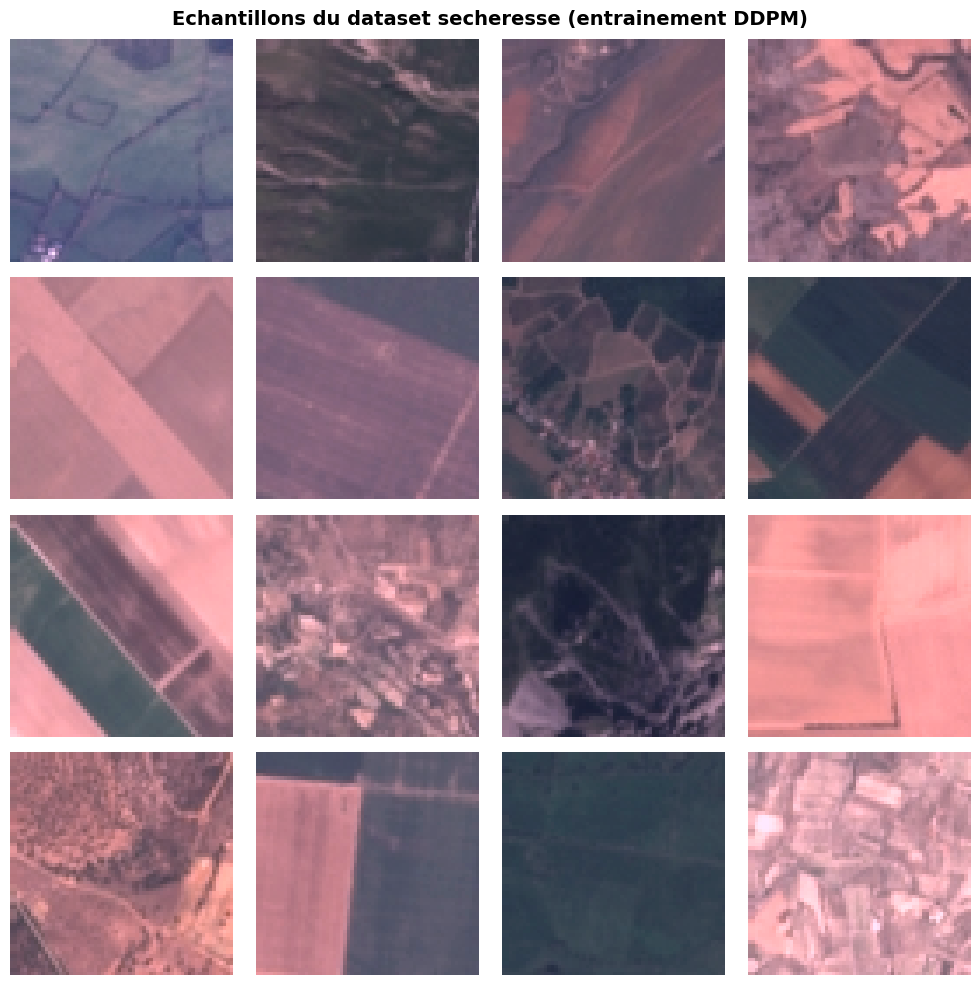

In [ ]:
# Visualiser quelques echantillons du dataset d'entrainement
show_image_grid(
    train_drought[:16], n_cols=4,
    title='Echantillons du dataset secheresse (entrainement DDPM)',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/comparisons/ddpm_training_samples.png"
)

In [ ]:
# DataLoader
train_dataset = TensorDataset(train_drought)
train_loader = DataLoader(
    train_dataset,
    batch_size=DIFFUSION['batch_size'],
    shuffle=True,
    drop_last=True
)

print(f"Nombre de batches par epoch : {len(train_loader)}")

Nombre de batches par epoch : 525


## 2. Visualisation du processus de diffusion

Avant d'entrainer, visualisons comment le bruit est ajoute progressivement.
Le processus forward de diffusion ajoute du bruit gaussien a chaque timestep,
jusqu'a obtenir du bruit pur a t=T.

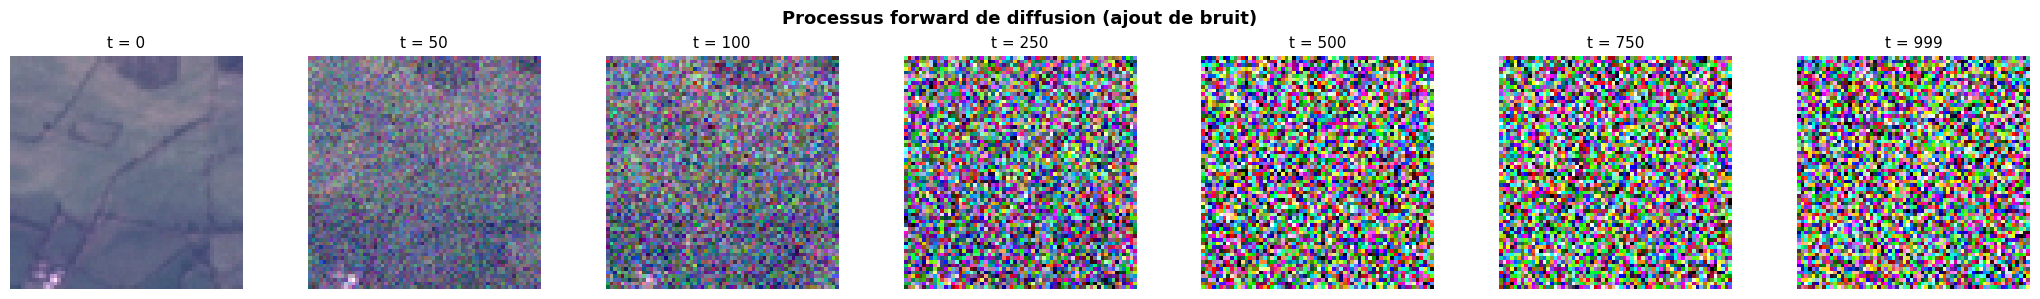

In [ ]:
from src.diffusion.scheduler import LinearNoiseScheduler

scheduler = LinearNoiseScheduler(
    n_timesteps=DIFFUSION['n_timesteps'],
    beta_start=DIFFUSION['beta_start'],
    beta_end=DIFFUSION['beta_end']
)

# Prendre une image
sample_img = train_drought[0:1]  # (1, 3, 64, 64)

# Afficher a differents timesteps
timesteps = [0, 50, 100, 250, 500, 750, 999]
fig, axes = plt.subplots(1, len(timesteps), figsize=(3 * len(timesteps), 3))

for i, t in enumerate(timesteps):
    t_tensor = torch.tensor([t])
    noisy, _ = scheduler.add_noise(sample_img, t_tensor)
    img_np = tensor_to_numpy(noisy[0])
    axes[i].imshow(img_np)
    axes[i].set_title(f't = {t}', fontsize=11)
    axes[i].axis('off')

plt.suptitle('Processus forward de diffusion (ajout de bruit)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{DRIVE_OUTPUTS}/evaluation/figures/ddpm_forward_process.png",
            dpi=150, bbox_inches='tight')
plt.show()

## 3. Initialisation et entrainement

Le `save_dir` pointe vers Google Drive pour que les checkpoints,
samples generes et historique des pertes survivent aux deconnexions Colab.

Si un checkpoint existe deja dans Drive, l'entrainement reprend
automatiquement depuis le dernier checkpoint (auto-resume).

**Sauvegarde automatique :**
- Checkpoints tous les 25 epochs dans `Drive/SatelliteGAN-Outputs/diffusion/checkpoints/`
- Samples generes dans `Drive/SatelliteGAN-Outputs/diffusion/samples/`
- Historique pertes (JSON) dans `Drive/SatelliteGAN-Outputs/diffusion/losses/`

**Auto-resume :** si l'entrainement est interrompu, relancer cette cellule.
Le trainer detecte le dernier checkpoint et reprend automatiquement.

In [ ]:
# Creer le trainer avec sauvegarde Drive
trainer = DiffusionTrainer(
    save_dir=f"{DRIVE_OUTPUTS}/diffusion"  # Checkpoints, samples, pertes -> Drive
)

# Compter les parametres
n_params = sum(p.numel() for p in trainer.model.parameters())
print(f"Parametres du U-Net : {n_params:,}")
print(f"Sauvegarde : {DRIVE_OUTPUTS}/diffusion")

Parametres du U-Net : 15,724,931
Sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion


In [ ]:
# Entrainer le modele
# Reduire n_epochs pour un test rapide (ex: 5-10 epochs)
# Pour l'entrainement complet, utiliser DIFFUSION['n_epochs'] (150)
N_EPOCHS = DIFFUSION['n_epochs']  # mettre 5 pour un test rapide

# L'auto-resume detecte les checkpoints existants dans Drive.
# Pour forcer une reprise depuis un checkpoint specifique :
#   history = trainer.train(train_loader, n_epochs=N_EPOCHS,
#                           resume_from=f"{DRIVE_OUTPUTS}/diffusion/checkpoints/epoch_50.pth")

history = trainer.train(train_loader, n_epochs=N_EPOCHS)

Sauvegarde activee : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion
Entrainement depuis le debut (epoch 1/150)


Epoch 1/150: 100%|██████████| 525/525 [01:38<00:00,  5.33it/s, loss=0.0274]


[Epoch 1] Loss: 0.0479


Epoch 2/150: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s, loss=0.0079]


[Epoch 2] Loss: 0.0186


Epoch 3/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0040]


[Epoch 3] Loss: 0.0170


Epoch 4/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0270]


[Epoch 4] Loss: 0.0151


Epoch 5/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0059]


[Epoch 5] Loss: 0.0152


Epoch 6/150: 100%|██████████| 525/525 [01:40<00:00,  5.24it/s, loss=0.0218]


[Epoch 6] Loss: 0.0138


Epoch 7/150: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s, loss=0.0068]


[Epoch 7] Loss: 0.0138


Epoch 8/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0128]


[Epoch 8] Loss: 0.0142


Epoch 9/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0038]


[Epoch 9] Loss: 0.0130


Epoch 10/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0384]


[Epoch 10] Loss: 0.0135


Epoch 11/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0081]


[Epoch 11] Loss: 0.0130


Epoch 12/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0070]


[Epoch 12] Loss: 0.0121


Epoch 13/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0048]


[Epoch 13] Loss: 0.0125


Epoch 14/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0070]


[Epoch 14] Loss: 0.0129


Epoch 15/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0220]


[Epoch 15] Loss: 0.0119


Epoch 16/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0057]


[Epoch 16] Loss: 0.0133


Epoch 17/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0272]


[Epoch 17] Loss: 0.0115


Epoch 18/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0115]


[Epoch 18] Loss: 0.0124


Epoch 19/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0130]


[Epoch 19] Loss: 0.0123


Epoch 20/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0162]


[Epoch 20] Loss: 0.0118


Epoch 21/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0137]


[Epoch 21] Loss: 0.0122


Epoch 22/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0064]


[Epoch 22] Loss: 0.0116


Epoch 23/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0048]


[Epoch 23] Loss: 0.0117


Epoch 24/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0076]


[Epoch 24] Loss: 0.0115


Epoch 25/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0055]


[Epoch 25] Loss: 0.0126
Checkpoint sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/checkpoints/epoch_25.pth


Fast sampling: 100%|██████████| 50/50 [00:02<00:00, 16.91it/s]


Samples sauvegardes : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/samples/epoch_25.png


Epoch 26/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0204]


[Epoch 26] Loss: 0.0118


Epoch 27/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0086]


[Epoch 27] Loss: 0.0117


Epoch 28/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0146]


[Epoch 28] Loss: 0.0123


Epoch 29/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0104]


[Epoch 29] Loss: 0.0126


Epoch 30/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0085]


[Epoch 30] Loss: 0.0124


Epoch 31/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0068]


[Epoch 31] Loss: 0.0125


Epoch 32/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0028]


[Epoch 32] Loss: 0.0125


Epoch 33/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0189]


[Epoch 33] Loss: 0.0117


Epoch 34/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0091]


[Epoch 34] Loss: 0.0118


Epoch 35/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0037]


[Epoch 35] Loss: 0.0122


Epoch 36/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0036]


[Epoch 36] Loss: 0.0119


Epoch 37/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0076]


[Epoch 37] Loss: 0.0124


Epoch 38/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0108]


[Epoch 38] Loss: 0.0118


Epoch 39/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0096]


[Epoch 39] Loss: 0.0122


Epoch 40/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0168]


[Epoch 40] Loss: 0.0115


Epoch 41/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0043]


[Epoch 41] Loss: 0.0110


Epoch 42/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0036]


[Epoch 42] Loss: 0.0111


Epoch 43/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0051]


[Epoch 43] Loss: 0.0115


Epoch 44/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0025]


[Epoch 44] Loss: 0.0118


Epoch 45/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0202]


[Epoch 45] Loss: 0.0120


Epoch 46/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0081]


[Epoch 46] Loss: 0.0122


Epoch 47/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0107]


[Epoch 47] Loss: 0.0114


Epoch 48/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0267]


[Epoch 48] Loss: 0.0120


Epoch 49/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0575]


[Epoch 49] Loss: 0.0119


Epoch 50/150: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s, loss=0.0122]


[Epoch 50] Loss: 0.0113
Checkpoint sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/checkpoints/epoch_50.pth


Fast sampling: 100%|██████████| 50/50 [00:02<00:00, 16.90it/s]


Samples sauvegardes : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/samples/epoch_50.png


Epoch 51/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0047]


[Epoch 51] Loss: 0.0118


Epoch 52/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0112]


[Epoch 52] Loss: 0.0109


Epoch 53/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0106]


[Epoch 53] Loss: 0.0115


Epoch 54/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0047]


[Epoch 54] Loss: 0.0118


Epoch 55/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0108]


[Epoch 55] Loss: 0.0118


Epoch 56/150: 100%|██████████| 525/525 [01:39<00:00,  5.30it/s, loss=0.0053]


[Epoch 56] Loss: 0.0122


Epoch 57/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0110]


[Epoch 57] Loss: 0.0111


Epoch 58/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0036]


[Epoch 58] Loss: 0.0120


Epoch 59/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0044]


[Epoch 59] Loss: 0.0121


Epoch 60/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0172]


[Epoch 60] Loss: 0.0117


Epoch 61/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0069]


[Epoch 61] Loss: 0.0118


Epoch 62/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0020]


[Epoch 62] Loss: 0.0114


Epoch 63/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0163]


[Epoch 63] Loss: 0.0112


Epoch 64/150: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s, loss=0.0120]


[Epoch 64] Loss: 0.0118


Epoch 65/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0150]


[Epoch 65] Loss: 0.0118


Epoch 66/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0073]


[Epoch 66] Loss: 0.0120


Epoch 67/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0138]


[Epoch 67] Loss: 0.0119


Epoch 68/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0326]


[Epoch 68] Loss: 0.0117


Epoch 69/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0178]


[Epoch 69] Loss: 0.0116


Epoch 70/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0101]


[Epoch 70] Loss: 0.0113


Epoch 71/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0049]


[Epoch 71] Loss: 0.0120


Epoch 72/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0128]


[Epoch 72] Loss: 0.0119


Epoch 73/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0056]


[Epoch 73] Loss: 0.0121


Epoch 74/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0083]


[Epoch 74] Loss: 0.0123


Epoch 75/150: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s, loss=0.0080]


[Epoch 75] Loss: 0.0115
Checkpoint sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/checkpoints/epoch_75.pth


Fast sampling: 100%|██████████| 50/50 [00:02<00:00, 16.93it/s]


Samples sauvegardes : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/samples/epoch_75.png


Epoch 76/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0061]


[Epoch 76] Loss: 0.0115


Epoch 77/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0054]


[Epoch 77] Loss: 0.0122


Epoch 78/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0095]


[Epoch 78] Loss: 0.0113


Epoch 79/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0043]


[Epoch 79] Loss: 0.0115


Epoch 80/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0023]


[Epoch 80] Loss: 0.0115


Epoch 81/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0128]


[Epoch 81] Loss: 0.0118


Epoch 82/150: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s, loss=0.0100]


[Epoch 82] Loss: 0.0115


Epoch 83/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0076]


[Epoch 83] Loss: 0.0114


Epoch 84/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0042]


[Epoch 84] Loss: 0.0111


Epoch 85/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0281]


[Epoch 85] Loss: 0.0112


Epoch 86/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0081]


[Epoch 86] Loss: 0.0111


Epoch 87/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0146]


[Epoch 87] Loss: 0.0116


Epoch 88/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0062]


[Epoch 88] Loss: 0.0113


Epoch 89/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0155]


[Epoch 89] Loss: 0.0112


Epoch 90/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0098]


[Epoch 90] Loss: 0.0108


Epoch 91/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0122]


[Epoch 91] Loss: 0.0118


Epoch 92/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0086]


[Epoch 92] Loss: 0.0116


Epoch 93/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0109]


[Epoch 93] Loss: 0.0116


Epoch 94/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0041]


[Epoch 94] Loss: 0.0108


Epoch 95/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0099]


[Epoch 95] Loss: 0.0110


Epoch 96/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0063]


[Epoch 96] Loss: 0.0116


Epoch 97/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0040]


[Epoch 97] Loss: 0.0106


Epoch 98/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0020]


[Epoch 98] Loss: 0.0113


Epoch 99/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0041]


[Epoch 99] Loss: 0.0110


Epoch 100/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0045]


[Epoch 100] Loss: 0.0113
Checkpoint sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/checkpoints/epoch_100.pth


Fast sampling: 100%|██████████| 50/50 [00:02<00:00, 16.89it/s]


Samples sauvegardes : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/samples/epoch_100.png


Epoch 101/150: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s, loss=0.0094]


[Epoch 101] Loss: 0.0108


Epoch 102/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0110]


[Epoch 102] Loss: 0.0109


Epoch 103/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0053]


[Epoch 103] Loss: 0.0115


Epoch 104/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0228]


[Epoch 104] Loss: 0.0106


Epoch 105/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0141]


[Epoch 105] Loss: 0.0115


Epoch 106/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0088]


[Epoch 106] Loss: 0.0111


Epoch 107/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0041]


[Epoch 107] Loss: 0.0108


Epoch 108/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0104]


[Epoch 108] Loss: 0.0113


Epoch 109/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0138]


[Epoch 109] Loss: 0.0113


Epoch 110/150: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s, loss=0.0133]


[Epoch 110] Loss: 0.0112


Epoch 111/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0104]


[Epoch 111] Loss: 0.0114


Epoch 112/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0077]


[Epoch 112] Loss: 0.0112


Epoch 113/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0041]


[Epoch 113] Loss: 0.0113


Epoch 114/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0071]


[Epoch 114] Loss: 0.0112


Epoch 115/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0115]


[Epoch 115] Loss: 0.0117


Epoch 116/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0396]


[Epoch 116] Loss: 0.0121


Epoch 117/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0031]


[Epoch 117] Loss: 0.0117


Epoch 118/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0066]


[Epoch 118] Loss: 0.0116


Epoch 119/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0039]


[Epoch 119] Loss: 0.0115


Epoch 120/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0124]


[Epoch 120] Loss: 0.0115


Epoch 121/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0062]


[Epoch 121] Loss: 0.0107


Epoch 122/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0085]


[Epoch 122] Loss: 0.0114


Epoch 123/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0064]


[Epoch 123] Loss: 0.0112


Epoch 124/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0188]


[Epoch 124] Loss: 0.0111


Epoch 125/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0115]


[Epoch 125] Loss: 0.0121
Checkpoint sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/checkpoints/epoch_125.pth


Fast sampling: 100%|██████████| 50/50 [00:02<00:00, 16.95it/s]


Samples sauvegardes : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/samples/epoch_125.png


Epoch 126/150: 100%|██████████| 525/525 [01:39<00:00,  5.26it/s, loss=0.0134]


[Epoch 126] Loss: 0.0115


Epoch 127/150: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s, loss=0.0111]


[Epoch 127] Loss: 0.0113


Epoch 128/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0103]


[Epoch 128] Loss: 0.0108


Epoch 129/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0143]


[Epoch 129] Loss: 0.0114


Epoch 130/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0081]


[Epoch 130] Loss: 0.0112


Epoch 131/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0014]


[Epoch 131] Loss: 0.0108


Epoch 132/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0073]


[Epoch 132] Loss: 0.0112


Epoch 133/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0042]


[Epoch 133] Loss: 0.0105


Epoch 134/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0061]


[Epoch 134] Loss: 0.0113


Epoch 135/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0009]


[Epoch 135] Loss: 0.0112


Epoch 136/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0045]


[Epoch 136] Loss: 0.0113


Epoch 137/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0084]


[Epoch 137] Loss: 0.0111


Epoch 138/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0071]


[Epoch 138] Loss: 0.0111


Epoch 139/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0228]


[Epoch 139] Loss: 0.0113


Epoch 140/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0260]


[Epoch 140] Loss: 0.0109


Epoch 141/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0134]


[Epoch 141] Loss: 0.0108


Epoch 142/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0287]


[Epoch 142] Loss: 0.0115


Epoch 143/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0051]


[Epoch 143] Loss: 0.0109


Epoch 144/150: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s, loss=0.0087]


[Epoch 144] Loss: 0.0116


Epoch 145/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0092]


[Epoch 145] Loss: 0.0110


Epoch 146/150: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s, loss=0.0080]


[Epoch 146] Loss: 0.0110


Epoch 147/150: 100%|██████████| 525/525 [01:39<00:00,  5.28it/s, loss=0.0079]


[Epoch 147] Loss: 0.0102


Epoch 148/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0216]


[Epoch 148] Loss: 0.0106


Epoch 149/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0072]


[Epoch 149] Loss: 0.0112


Epoch 150/150: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s, loss=0.0015]


[Epoch 150] Loss: 0.0112
Checkpoint sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/checkpoints/epoch_150.pth


Fast sampling: 100%|██████████| 50/50 [00:02<00:00, 16.93it/s]


Samples sauvegardes : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/samples/epoch_150.png
Modele final sauvegarde : /content/drive/MyDrive/SatelliteGAN-Outputs/diffusion/checkpoints/final.pth


## 4. Courbe de perte

La perte du DDPM est le MSE entre le bruit reel et le bruit predit par le U-Net.
Elle devrait diminuer regulierement au fil des epochs.

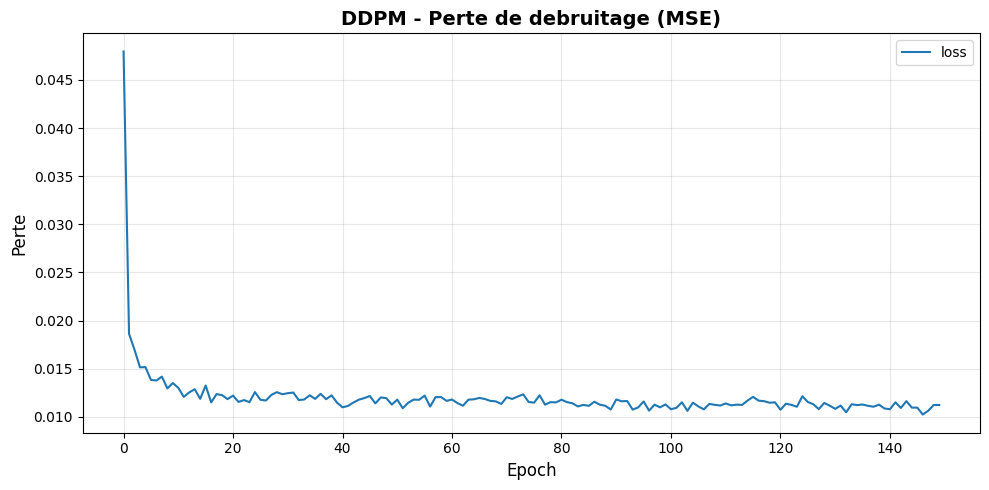

In [ ]:
# Afficher les courbes de perte (sauvegardees dans Drive)
plot_training_losses(
    history,
    title='DDPM - Perte de debruitage (MSE)',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/figures/ddpm_losses.png"
)

## 5. Generation d'images

On genere des images en partant de bruit pur et en utilisant le processus
reverse de diffusion. Le sampling rapide utilise 50 pas au lieu de 1000
pour un temps de generation raisonnable. L'EMA ameliore la qualite.

Generation d'images (sampling rapide)...


Fast sampling: 100%|██████████| 50/50 [00:02<00:00, 16.97it/s]


Figure sauvegardee : /content/drive/MyDrive/SatelliteGAN-Outputs/evaluation/comparisons/ddpm_generated.png


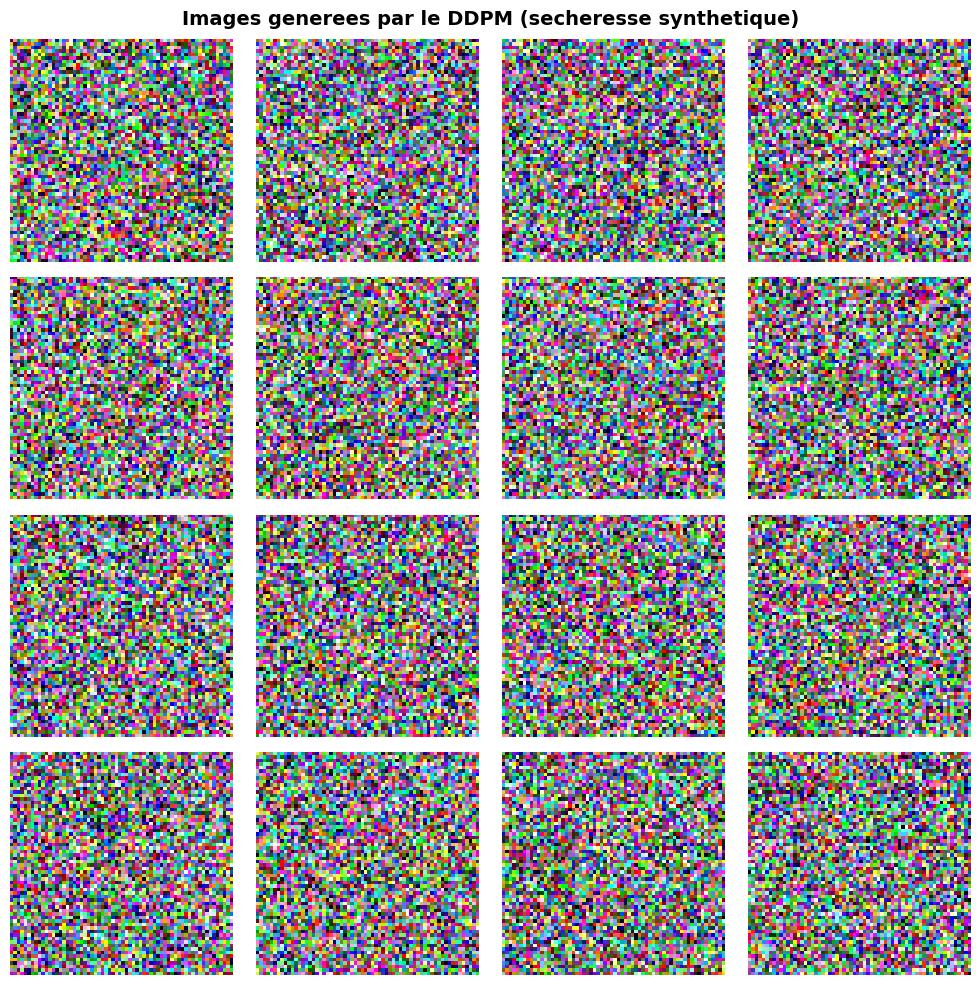

In [ ]:
# Generer des images (sampling rapide avec EMA)
print("Generation d'images (sampling rapide)...")
generated = trainer.generate(n_samples=16, use_ema=True, fast=True)

show_image_grid(
    generated.cpu(), n_cols=4,
    title='Images generees par le DDPM (secheresse synthetique)',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/comparisons/ddpm_generated.png"
)

Figure sauvegardee : /content/drive/MyDrive/SatelliteGAN-Outputs/evaluation/comparisons/ddpm_comparison.png


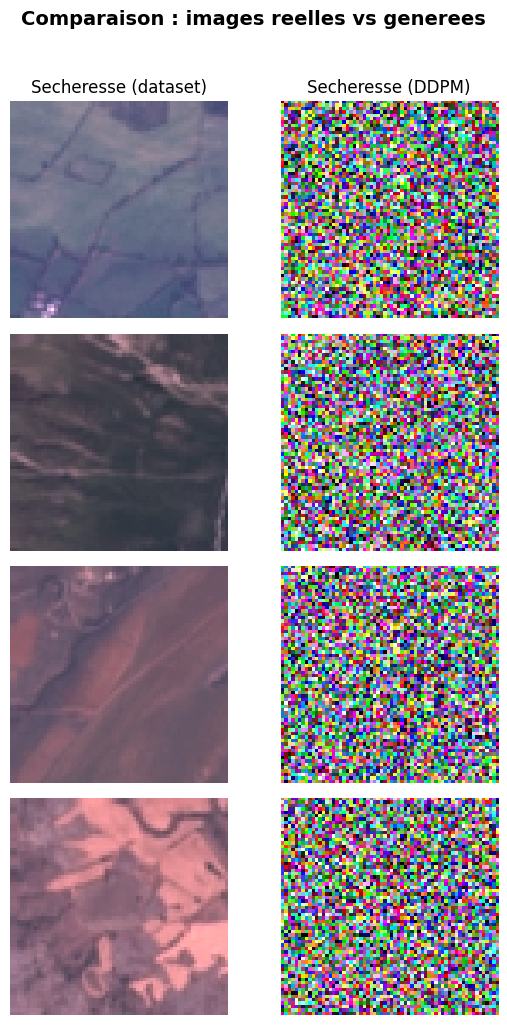

In [ ]:
# Comparaison avec les vraies images de secheresse
show_comparison(
    train_drought[:8].cpu(), generated[:8].cpu(),
    n_samples=4,
    labels=('Secheresse (dataset)', 'Secheresse (DDPM)'),
    title='Comparaison : images reelles vs generees',
    save_path=f"{DRIVE_OUTPUTS}/evaluation/comparisons/ddpm_comparison.png"
)

## Resume

**Observations :**
- Le DDPM apprend a generer des images satellites de secheresse
- Les images generees montrent des textures et couleurs coherentes
- Le sampling rapide (50 pas) produit des resultats raisonnables
- L'EMA ameliore sensiblement la qualite des generations

**Sauvegardes dans Drive :**
- `diffusion/checkpoints/` : checkpoints toutes les 25 epochs + final.pth
- `diffusion/samples/` : images generees a chaque sauvegarde
- `diffusion/losses/loss_history.json` : historique complet des pertes
- `evaluation/figures/ddpm_losses.png` : courbe de perte
- `evaluation/comparisons/ddpm_generated.png` : grille d'images generees
- `evaluation/comparisons/ddpm_comparison.png` : comparaison reel vs genere

**Prochaine etape :** Evaluation quantitative avec SSIM, PSNR et FID
dans le notebook `04_evaluation_results.ipynb`.